In [5]:
from flygym.mujoco.arena.food_sources import FoodSource
from flygym.mujoco.arena.food_environment import OdorArenaEnriched
import numpy as np
import os
from pathlib import Path
import logging
from tqdm import trange
from flygym.mujoco.arena import OdorArena, OdorArenaEnriched
import matplotlib.pyplot as plt
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF


# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
sources = [FoodSource([24, 0, 1.5], [1, 3], 12), FoodSource([8, -4, 1.5], [3, 7], 10), FoodSource([16, 4, 1.5], [2, 6], 10), FoodSource([12, -8, 1.5], [5, 3], 17), FoodSource([20, 3, 1.5], [9, 3], 20)]

logging.basicConfig(level=logging.INFO)

marker_colors = [
    [255, 127, 14],
    [31, 119, 180],
    [255, 192, 203],
    [255, 0, 0],
    [0, 255, 0],
]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])


(-0.5, 799.5, 607.5, -0.5)

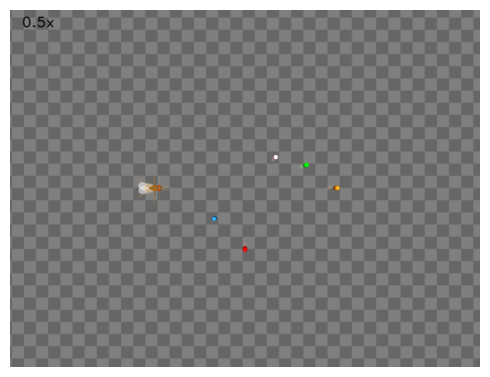

In [9]:
# Set up the arena
arena = OdorArenaEnriched(
    food_sources=sources,
    size=(50,50),
    diffuse_func=lambda x: x**-2,
    marker_size=0.3,
    marker_colors=marker_colors,
    key_angle=True,  # we add this boolean so that we compute the key for the valence dictionary by using the angle formed in the complex plane
)
# Add the NeuroMechFLy
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=10,
)
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
# fig.savefig("./outputs/olfaction_env.png")

In [10]:
# Let's start the simulation
decision_interval = 0.01
run_time = 40  # sim.simulation_time / 2
num_decision_steps = int(run_time / decision_interval)
logging.info("Number of decision steps: ", num_decision_steps)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

obs_hist = []
odor_history = []
obs, _ = sim.reset()

# Let's choose the source towards which the fly will walk
source = sim.choose_odor_exploration()
prev_reward = None
logging.info("Going to the source ", source + 1)

# Let's start the exploration
for i in trange(num_decision_steps):
    # compute the control signal to go towards the chosen source
    control_signal = arena.generate_specific_turning_control(source, sim)
    for _ in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal, False, True)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

        if reward != None:
            # let's check if the fly has actually reached a new source
            if prev_reward != reward:
                print(reward)
                # if it has, the sim.odor_scores, sim.key_odor_scores are updated and a new source to be reached is computed
                sim.update_odor_scores(source)
                sim.update_odor_scores_key(source)
                source = sim.choose_odor_exploration()
                logging.info("new source", source + 1)
                logging.info(sim.odor_scores)
                prev_reward = reward
        if terminated:
            logging.info("Out of time")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if truncated:
            logging.info("No food source was reached, simulation is truncated")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break

  4%|▎         | 142/4000 [00:44<19:47,  3.25it/s]

10


 10%|▉         | 393/4000 [02:06<17:27,  3.44it/s]

20


 12%|█▎        | 500/4000 [02:39<18:37,  3.13it/s]


KeyboardInterrupt: 

In [11]:
# Let's check the confidence level for the fly's memory related to the different sources
print(sim.odor_scores)
# Let's check the fly's memory
print(sim.fly_valence_dictionary)
# Let's check the confidence level for the fly's memory related to the different smells
print(sim.key_odor_scores)

[ 0. 15.  0.  0. 15.]
{0.4048917862850834: 10, 1.2490457723982544: 20}
{0.32175055439664224: 0, 0.4048917862850834: 13.0, 1.0303768265243125: 0, 1.2490457723982544: 14.0}


In [12]:
# Choose a name to save both the video and the trajectory
name = "food_source_implementation"
path = Path(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}")
os.mkdir(path)

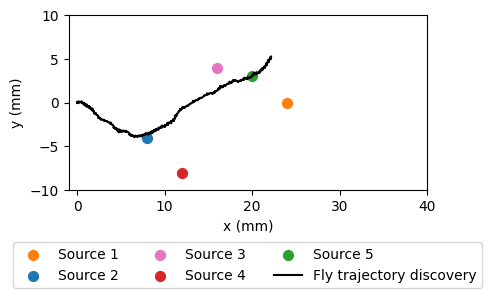

In [13]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [arena.odor_source[0, 0]],
    [arena.odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Source 1",
)
ax.scatter(
    [arena.odor_source[1, 0]],
    [arena.odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Source 2",
)
ax.scatter(
    [arena.odor_source[2, 0]],
    [arena.odor_source[2, 1]],
    marker="o",
    color="tab:pink",
    s=50,
    label="Source 3",
)
ax.scatter(
    [arena.odor_source[3, 0]],
    [arena.odor_source[3, 1]],
    marker="o",
    color="tab:red",
    s=50,
    label="Source 4",
)
ax.scatter(
    [arena.odor_source[4, 0]],
    [arena.odor_source[4, 1]],
    marker="o",
    color="tab:green",
    s=50,
    label="Source 5",
)
ax.plot(
    fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory discovery"
)
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png"
)

In [14]:
# save the video
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video_exploration.mp4"
)

In [19]:
# In order for the fly to walk around the arena based on its internal state, it must have visited all the sources before
if not(sim.all_sources_explored()):
    # The fly is respawned
    obs, _ = sim.respawn()
    # Let the exploration begin
    decision_interval = 0.01
    run_time = sim.simulation_time / 2
    num_decision_steps = int(run_time / decision_interval)
    logging.info("Number of decision steps: ", num_decision_steps)
    physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
    logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

    _obs_hist = []
    _odor_history = []

    # Bool to see if simulation is done
    sim_end = False
    # Get fly's hunger state
    hunger_limits = sim.food_requirements
    # To keep track of the previous internal state
    prev_int_state = ""

    prev_reward = None
    source = None

    # Run simulation
    # For each decision step
    for i in trange(num_decision_steps):
        if not (sim_end):
            # Check where the fly's hunger level is at
            int_state = sim.compute_internal_state()
            # Decide which source to go to based on the internal state
            if int_state == "starving":
                # the fly will reach the closest source
                source = sim.compute_closest_source(obs)
            elif int_state == "hungry":
                # the fly will reach the smell that has the highest reward
                # the fly chooses the closest source of this smell to go to
                source = arena.compute_richest_closest_source(obs)
            else:
                if source == None:
                    # the fly will decide which source to go to based on its internal table
                    source = sim.choose_angle_key_odor_exploration()

            control_signal = arena.generate_specific_turning_control(source, sim)
            # Make environment step and reward fly if it gets to a food source
            for _ in range(physics_steps_per_decision_step):
                obs, reward, terminated, truncated, _ = sim.step(
                    control_signal, False, True
                )
                rendered_img = sim.render(True)
                if rendered_img is not None:
                    # record odor intensity too for video
                    _odor_history.append(obs["odor_intensity"])
                _obs_hist.append(obs)

                # If fly gets to food source, simulation does not end
                # fly keeps walking based on its internal state
                if reward != None:
                    if prev_reward != reward:
                        # sim_end = True
                        # if it has, the sim.odor_scores, sim.key_odor_scores are updated and a new source to be reached is computed
                        sim.update_odor_scores_key(source)
                        source_reward = sim.compute_closest_source(obs)
                        logging.info("Fly got to food source", source_reward)
                        logging.info("Elapsed time in the simulation", sim.curr_time)
                        prev_reward = reward
                        print(reward)
                        source = None
                        break
                    # break
                # If fly has no food left, end simulation (death)
                # if obs["food_stocked"] < 0:
                #    sim_end = True
                #    logging.info("Fly died")
                #    break

                # If simulation should be terminated or truncted, end simulation
                if terminated:
                    logging.info("Out of time")
                    logging.info("Elapsed time in the simulation", sim.curr_time)
                    sim_end = True
                    break
                if truncated:
                    logging.info("No food source was reached, simulation is truncated")
                    logging.info("Elapsed time in the simulation", sim.curr_time)
                    sim_end = True
                    break

  0%|          | 0/500 [00:00<?, ?it/s]

4


  0%|          | 1/500 [00:00<01:56,  4.29it/s]

4


  0%|          | 2/500 [00:00<02:01,  4.10it/s]

4


  1%|          | 3/500 [00:00<02:01,  4.08it/s]

4


  1%|          | 4/500 [00:01<02:08,  3.85it/s]

4


  1%|          | 5/500 [00:01<02:07,  3.88it/s]

4


  1%|          | 6/500 [00:01<02:09,  3.81it/s]

4


  1%|▏         | 7/500 [00:01<02:13,  3.68it/s]

4


  2%|▏         | 8/500 [00:02<02:21,  3.47it/s]

4


  2%|▏         | 9/500 [00:02<02:23,  3.42it/s]

4


  2%|▏         | 10/500 [00:02<02:26,  3.34it/s]

4


  2%|▏         | 11/500 [00:03<02:32,  3.21it/s]

4


  2%|▏         | 12/500 [00:03<02:40,  3.04it/s]

4


  3%|▎         | 13/500 [00:03<02:31,  3.22it/s]

4


  3%|▎         | 14/500 [00:04<02:29,  3.24it/s]

4


  3%|▎         | 15/500 [00:04<02:35,  3.12it/s]

4


  3%|▎         | 16/500 [00:04<02:39,  3.03it/s]

4


  3%|▎         | 17/500 [00:05<02:32,  3.16it/s]

4


  4%|▎         | 18/500 [00:05<02:37,  3.05it/s]

4


  4%|▍         | 19/500 [00:05<02:54,  2.75it/s]

4


  4%|▍         | 20/500 [00:06<03:22,  2.38it/s]

4


  4%|▍         | 21/500 [00:06<03:10,  2.52it/s]

4


  4%|▍         | 22/500 [00:07<03:03,  2.61it/s]

4


  5%|▍         | 23/500 [00:07<02:51,  2.79it/s]

4


  5%|▍         | 24/500 [00:07<02:49,  2.81it/s]

4


  5%|▌         | 25/500 [00:08<02:43,  2.91it/s]

4


  5%|▌         | 26/500 [00:08<02:34,  3.06it/s]

4


  5%|▌         | 27/500 [00:08<02:44,  2.88it/s]

4


  6%|▌         | 28/500 [00:09<03:01,  2.60it/s]

4


  6%|▌         | 29/500 [00:09<02:56,  2.67it/s]

4


  6%|▌         | 30/500 [00:09<02:43,  2.87it/s]

4


  6%|▌         | 31/500 [00:10<02:44,  2.84it/s]

4


  6%|▋         | 32/500 [00:10<02:46,  2.82it/s]

4


  7%|▋         | 33/500 [00:10<02:45,  2.83it/s]

4


  7%|▋         | 34/500 [00:11<02:33,  3.04it/s]

4


  7%|▋         | 35/500 [00:11<02:28,  3.12it/s]

4


  7%|▋         | 36/500 [00:11<02:28,  3.11it/s]

4


  7%|▋         | 37/500 [00:12<02:22,  3.25it/s]

4


  8%|▊         | 38/500 [00:12<02:16,  3.39it/s]

4


  8%|▊         | 39/500 [00:12<02:28,  3.11it/s]

4


  8%|▊         | 40/500 [00:13<02:42,  2.82it/s]

4


  8%|▊         | 41/500 [00:13<02:53,  2.65it/s]

4


  8%|▊         | 42/500 [00:13<02:48,  2.72it/s]

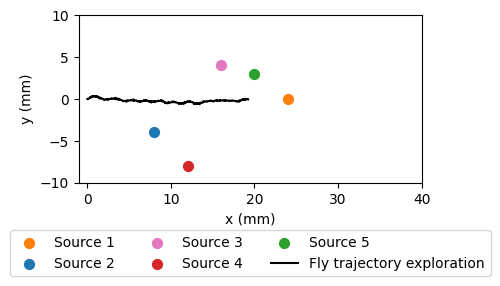

In [17]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in _obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [arena.odor_source[0, 0]],
    [arena.odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Source 1",
)
ax.scatter(
    [arena.odor_source[1, 0]],
    [arena.odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Source 2",
)
ax.scatter(
    [arena.odor_source[2, 0]],
    [arena.odor_source[2, 1]],
    marker="o",
    color="tab:pink",
    s=50,
    label="Source 3",
)
ax.scatter(
    [arena.odor_source[3, 0]],
    [arena.odor_source[3, 1]],
    marker="o",
    color="tab:red",
    s=50,
    label="Source 4",
)
ax.scatter(
    [arena.odor_source[4, 0]],
    [arena.odor_source[4, 1]],
    marker="o",
    color="tab:green",
    s=50,
    label="Source 5",
)
ax.plot(
    fly_pos_hist[:, 0],
    fly_pos_hist[:, 1],
    color="k",
    label="Fly trajectory exploration",
)
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory_respawn.png"
)

In [ ]:
# Save the video
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video_respawn_internal_state.mp4"
)

In [ ]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
_fly_pos_hist = np.array([obs["fly"][0, :2] for obs in _obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [arena.odor_source[0, 0]],
    [arena.odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Source 1",
)
ax.scatter(
    [arena.odor_source[1, 0]],
    [arena.odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Source 2",
)
ax.scatter(
    [arena.odor_source[2, 0]],
    [arena.odor_source[2, 1]],
    marker="o",
    color="tab:pink",
    s=50,
    label="Source 3",
)
ax.scatter(
    [arena.odor_source[3, 0]],
    [arena.odor_source[3, 1]],
    marker="o",
    color="tab:red",
    s=50,
    label="Source 4",
)
ax.scatter(
    [arena.odor_source[4, 0]],
    [arena.odor_source[4, 1]],
    marker="o",
    color="tab:green",
    s=50,
    label="Source 5",
)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Discovering phase")
ax.plot(_fly_pos_hist[:, 0], _fly_pos_hist[:, 1], color="r", label="Exploration phase")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory_respawn.png"
)